In [549]:
import pandas as pd
import re

In [550]:
def clean_script(script):
    script = script.lstrip('<pre>').split('\nTHE END')[0]
    script = script.replace('McGARRY', 'MCGARRY')
    script = script.replace('CUT TO:\n\n', 'CUT TO: ')
    script_ = re.sub(r'([A-Z])(\nCUT TO:)', r'\1\n\2',  script)
    script = script_.replace('FADE OUT.\nEND', '')
    script = script_.replace('FADE OUT.\n\nEND ', '')
    script = script.rstrip('\n')
     
    return script#' '.join([act.split('\n\n',1)[1] for act in script.split('ACT ')[1:]])


In [551]:
def make_script_df(script, episode_num):
    bits = script.split('\n\n')
    return pd.DataFrame({'elements':bits, 'episode': [episode_num for ik in range(len(bits))]})

In [552]:
def parse_stage_dir(script_df):
    stage_dir = []
    for ik, bit in enumerate(script_df.elements):
        if (bit.split('\n')[0].isupper() == False) and ('[' not in bit.split('\n')[0]):
            stage_dir.append(1)
            script_df.loc[ik, 'elements'] = bit.replace('\n', ' ')
        else:
            stage_dir.append(0)
            
    script_df['stage_dir'] = stage_dir
    return script_df

In [553]:
def parse_scene_set(script_df):
    scene_set = []
    for elem in script_df.elements:
        lines = elem.split('\n')
        if ('-' in lines[0]) and (lines[0].isupper()):
            scene_set.append(1)
        else:
            scene_set.append(0)

    script_df['scene_set'] = scene_set
    return script_df

In [554]:
import numpy as np

def parse_lines_characters(script_df):
    line = []
    character = []
    deliv_dir = []
    audio_dir = []

    for ik in range(len(script_df.elements)):
        if (script_df.iloc[ik]['scene_set'] == 0) and (script_df.iloc[ik]['stage_dir'] == 0):
            tmp_elem  = script_df.iloc[ik]['elements'].split('\n')
            
            if len(tmp_elem)>1:
                # character name & audio delivery notes
                tmp_audio_dir = tmp_elem[0].split(' [')
                if len(tmp_audio_dir)>1:
                    audio_dir.append(tmp_audio_dir[1].strip(']'))
                    character.append(tmp_audio_dir[0])
                else:
                    if (tmp_audio_dir[0].isupper() == True):
                        audio_dir.append(np.nan)
                        character.append(tmp_audio_dir[0])
                    else:
                        character.append(' ')
                        audio_dir.append(np.nan)

                # line & acting delivery notes
                tmp_deliv_dir = tmp_elem[1].split('] ')
                if len(tmp_deliv_dir)>1:
                    deliv_dir.append(tmp_deliv_dir[0].strip('['))
                    line.append(tmp_deliv_dir[1])
                else:
                    line.append(tmp_deliv_dir[0])
                    deliv_dir.append(np.nan)
            else:
                line.append(np.nan)
                character.append('Drop')
                deliv_dir.append(np.nan)
                audio_dir.append(np.nan)

        else:
            line.append(np.nan)
            character.append(' ')
            deliv_dir.append(np.nan)
            audio_dir.append(np.nan)

    script_df['line'] = line
    script_df['character'] = character
    script_df['deliv_dir'] = deliv_dir
    script_df['audio_dir'] = audio_dir
    
    return script_df

In [560]:
# load scraped scripts
ww_nonSorkin_df = pd.read_json('WW_nonSorkin.json')

In [561]:
# pull apart scripts
script_dfs= [parse_lines_characters(parse_scene_set(parse_stage_dir(make_script_df(clean_script(text),ik+1)))) for ik, text in enumerate(ww_nonSorkin_df.text)]

# concatenate scripts
ww_nonSorkin_dfs = pd.concat(script_dfs, axis=0, join='outer')

In [572]:
# drop rows with character names that aren't characters
for char in [' ', 'DISSOLVE TO', 'FADE OUT.', 'SMASH CUT TO: MAIN TITLES.', 'THE WEST WING', 'ACT ONE', 'ACT TWO', 'END TEASER', 'Drop']:
    ww_nonSorkin_dfs = ww_nonSorkin_dfs[~ww_nonSorkin_dfs['character'].str.contains( char)]



In [573]:
ww_nonSorkin_dfs['label'] = ['NOT!' for ik in range(len(ww_nonSorkin_dfs))]

In [555]:
# load scraped scripts
ww_df = pd.read_json('WW.json')

In [557]:
# pull apart scripts
script_dfs= [parse_lines_characters(parse_scene_set(parse_stage_dir(make_script_df(clean_script(text),ik+1)))) for ik, text in enumerate(ww_df.text)]

# concatenate scripts
ww_dfs = pd.concat(script_dfs, axis=0, join='outer')

In [558]:
# drop rows with character names that aren't characters
for char in [' ', 'DISSOLVE TO', 'FADE OUT.', 'SMASH CUT TO: MAIN TITLES.', 'THE WEST WING', 'ACT ONE', 'ACT TWO', 'END TEASER', 'Drop']:
    ww_dfs = ww_dfs[~ww_dfs['character'].str.contains( char)]


In [559]:
ww_dfs['label'] = ['SORKIN' for ik in range(len(ww_dfs))]

In [577]:
ww_sub_dfs = ww_dfs.sample(n = len(ww_nonSorkin_dfs))

In [578]:
ww_SnS_dfs = pd.concat([ww_nonSorkin_dfs,ww_sub_dfs], axis=0, join='outer')

In [565]:
import spacy
nlp = spacy.load('en')

In [602]:
from collections import Counter
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(5000)]
    

In [603]:
commonwords = []

for label in ['Sorkin','NOT!'] :
    _text = ' '.join(ww_SnS_dfs['line'][ww_SnS_dfs.label == label])
    _words = bag_of_words(nlp(_text))
    commonwords = list(set(commonwords+_words))

In [604]:
quotes = [[nlp(ww_SnS_dfs.iloc[ik]['line']), ww_SnS_dfs.iloc[ik]['label']] for ik in range(len(ww_SnS_dfs))]

In [605]:
quotes_df = pd.DataFrame(quotes)

In [634]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.

# POS dict
pos_d = {'VERB':'verb_ct', 'NOUN':'noun_ct', 'ADV':'adv_ct', 'ADP':'adp_ct', 
         'PROPN':'propn_ct', 'ADJ':'adj_ct', 'DET':'det_ct', 'PUNCT':'punct_ct'}

def bow_features(quotes, common_words, **kwargs):
    print(len(quotes))
#     df2 = {'line': [sentence[0] for sentence in sentences], 'character': [sentence[1] for sentence in sentences]}
    
    # sentence stats
    sent_stats = ['comma_ct', 'word_ct', 'adv_ct', 'adp_ct', 'propn_ct', 'adj_ct', 'punct_ct'] #'verb_ct', 'noun_ct','det_ct',
    if 'sent_stats' in kwargs:
        df = pd.DataFrame(columns=list(common_words) + sent_stats)
        cols = list(common_words)+sent_stats
#         df.loc[:, sent_stats] = 0
    else:
        df = pd.DataFrame(columns=common_words)
        cols = list(common_words)
    
    df.loc[:, common_words] = 0
    for col in df.columns:
        df[col] = np.zeros(len(quotes[0]))
    df['line'] = quotes[0] 
    df['character'] = quotes[1]
    
    print('made it to the loop')
    # Process each row, counting the occurrence of words in each sentence.
    for i, quote in enumerate(df['line']):
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in quote
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            try:
                df.loc[i, word] += 1
            except:
                print(words)
        
        # add sentence features
        if 'sent_stats' in kwargs:
            commas = 0
            for token in quote:
                if token.orth_ == ',':
                    commas += 1
            df.loc[i, 'comma_ct'] = commas
                    
            c = Counter([token.pos_ for token in quote])
            for key in pos_d.keys():
                if key in c.keys():
                    df.loc[i, pos_d[key]] = c[key]
                else:
                    df.loc[i, pos_d[key]] = c[key]
            
            df.loc[i, 'word_ct'] = len([token for token in quote if (not token.is_punct)])

        # This counter is just to make sure the kernel didn't hang.
        if i % 1000 == 0:
            print("Processing row {}".format(i))
            
    return df

In [635]:
word_counts2 = bow_features(quotes_df, words, sent_stats=True)

8128
made it to the loop
Processing row 0
['the', 'line']
['want', 'line', 'drink']
Processing row 1000
Processing row 2000
['the', 'report', 'administration', 'view', 'that', 'be', 'line', 'what']
['so', 'award', 'roll', 'that', 'will', 'line']
['-PRON-', 'give', 'line', 'say']
['-PRON-', 'when', '-PRON-', 'line', 'be']
['-PRON-', 'wife', 'budget', '-PRON-', 'be', 'line', 'do', 'not', 'word']
['-PRON-', 'take', 'russell', 'job', 'this', 'not', 'line', 'none']
['and', 'hold', 'line', 'make', 'day', 'story']
Processing row 3000
Processing row 4000
['in', 'red', 'line', 'sir']
['-PRON-', 'read', 'line']
Processing row 5000
['-PRON-', 'be', 'residence', 'secure', 'phone', 'line']
Processing row 6000
['everybody', 'line', 'only', 'drink']
['just', 'stuff', '-PRON-', 'panic', 'line']
Processing row 7000
['then', 'maybe', 'line']
Processing row 8000


(0, 400)

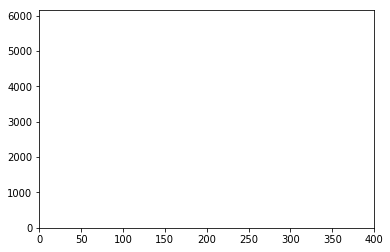

In [636]:
import matplotlib.pyplot as plt
# cts, ints, patches = plt.hist(word_counts2.iloc[:, ~word_counts2.columns.isin(['character', 'line'])].sum(axis=0), bins = 500)
cts, ints, patches = plt.hist(word_counts2['comma_ct'], bins = 500)


plt.xlim([0, 400])

In [637]:
from sklearn.model_selection import train_test_split

Y = word_counts2['character']
X = word_counts2.iloc[:, ~word_counts2.columns.isin(['character','line'])]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=0)

In [638]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

y_pred = train.predict(X_test)
pd.crosstab(y_pred, y_test, dropna=False)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(5689, 1761) (5689,)
Training set score: 0.7222710493935666

Test set score: 0.6277162771627717


character,NOT!,SORKIN
row_0,,
NOT!,724,429
SORKIN,479,807


In [639]:
len(y_test[y_test == 'SORKIN'])/len(y_test)

0.5067650676506765